In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import parent
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import data


In [33]:

BATCH_SIZE = 32
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
working_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

net = inverseConsistentNet.InverseConsistentAffineNet(
    networks.ConvolutionalMatrixNet(dimension=3),
    lmbda=100,
    input_shape=working_shape,
)

net.load_state_dict(torch.load("../results/affine_knee_lambdaserver_2/knee_aligner_resi_net61500"))

<All keys matched successfully>

In [21]:
_, medresknees = data.get_knees_dataset()

100%|██████████| 240/240 [00:11<00:00, 20.71it/s]


In [35]:
net.cuda()

InverseConsistentAffineNet(
  (regis_net): ConvolutionalMatrixNet(
    (convs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (5): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (dense2): Linear(in_features=512, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=12, bias=True)
  )
)

In [23]:
def make_batch():
    image = torch.cat([random.choice(medresknees) for _ in range(BATCH_SIZE)])
    image = image[:, None]
    image = image.cuda()
    return image

In [24]:
moving_image, fixed_image = make_batch(), make_batch()

In [36]:
net(moving_image, fixed_image)

[tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0004, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1582, device='cuda:0', grad_fn=<MulBackward0>)]

In [31]:
net.matrix_AB

tensor([[[ 1.0044e+00,  7.2055e-03,  8.3092e-03,  2.8491e-02],
         [-2.9143e-02,  9.2744e-01,  3.0303e-02, -1.3048e-02],
         [-1.3701e-03,  2.9728e-02,  1.0032e+00, -4.5818e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.9195e-01,  6.8089e-04, -2.9148e-03, -1.6866e-02],
         [-1.6649e-02,  9.5565e-01,  2.6490e-02, -1.3749e-02],
         [-2.6237e-03,  1.4834e-02,  9.8802e-01,  5.2259e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.5370e-01,  8.7381e-03, -4.5667e-03, -1.1328e-02],
         [-1.3750e-03,  9.8255e-01,  9.2022e-03, -6.7891e-03],
         [-8.7778e-03,  2.1103e-02,  9.3477e-01,  6.4375e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.9731e-01,  4.1086e-03,  3.6534e-03,  1.2374e-02],
         [ 1.9119e-02,  1.0470e+00, -2.7726e-02,  1.5532e-02],
         [ 2.8273e-03, -9.6264e-03,  9.8583e-01,  1.3246e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

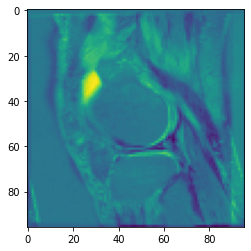

In [43]:
plt.imshow(fixed_image[1, 0, 10].cpu() - net.warped_image_A[1, 0, 10].cpu().detach())

##plt.imshow(net.warped_image_A[0, 0, 10].cpu().detach())
#plt.show()
#plt.imshow(net.warped_image_B[0, 0, 10].cpu().detach())

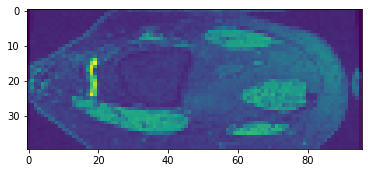

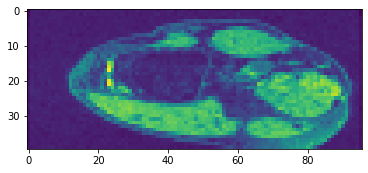

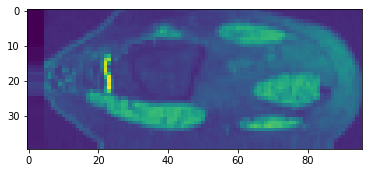

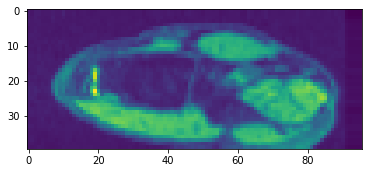

In [44]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())

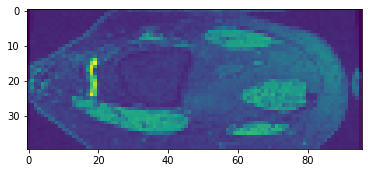

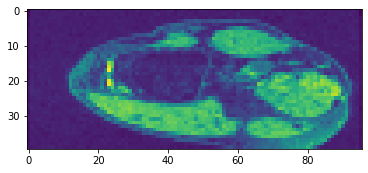

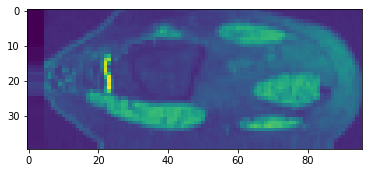

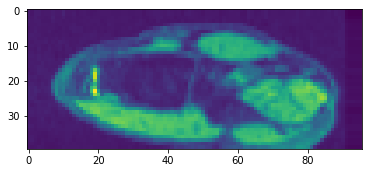

In [37]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())

In [50]:
net.matrix_AB[20].cpu().detach().numpy()

array([[ 0.97595763,  0.00672266,  0.00006951, -0.01163099],
       [ 0.03015379,  1.0754728 , -0.03506744,  0.01556389],
       [ 0.00235689, -0.02747279,  0.955216  ,  0.05459239],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [49]:
import numpy as np
np.set_printoptions(suppress=True)